# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

# Import Data

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class:  frog


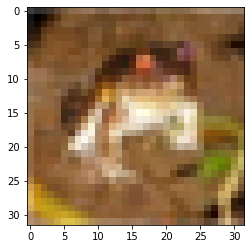

class:  truck


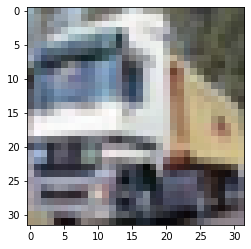

class:  truck


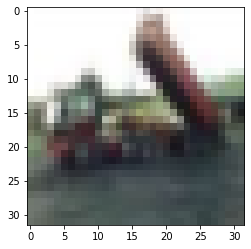

class:  deer


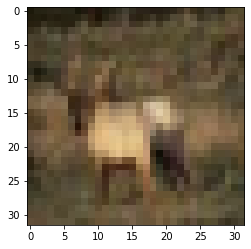

class:  automobile


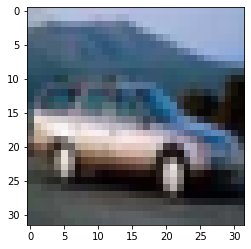

class:  automobile


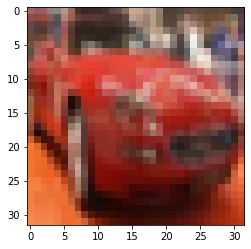

class:  bird


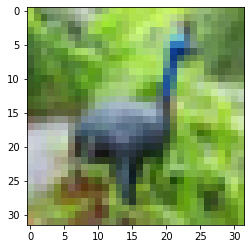

class:  horse


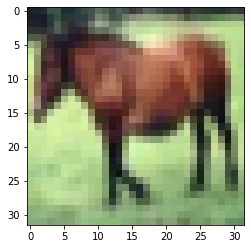

class:  ship


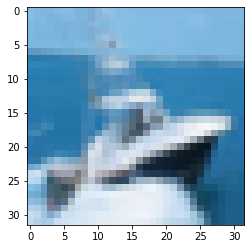

class:  cat


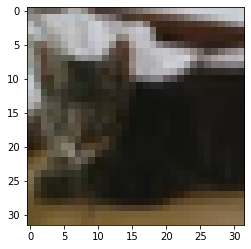

In [6]:
for i in range(10):
    print('class: ',class_names[int(y_train[i])])
    plt.imshow(X_train[i])
    plt.show()

# Preprocessing

## Normalise

In [7]:
X_train.min(),X_train.max()

(0, 255)

In [8]:
X_train = X_train/255

In [9]:
X_test = X_test/255

In [10]:
X_train.min(),X_train.max()

(0.0, 1.0)

## One hot encode

In [11]:
y_train[0]

array([6], dtype=uint8)

In [12]:
#unique classes
int(pd.DataFrame(y_train).nunique())

10

In [13]:
y_train_encoded = to_categorical(y_train, num_classes= 10)

In [14]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [15]:
y_test_encoded = to_categorical(y_test, num_classes= 10)

# Models

In [16]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## 1) Baseline

In [17]:
baseline = Sequential()

baseline.add(Conv2D(input_shape = (32,32,3), 
                    filters = 32, 
                    kernel_size = (4,4),
                    kernel_initializer = 'he_normal'))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
             
baseline.add(MaxPool2D(pool_size = (2,2)))
             
baseline.add(Conv2D(filters = 64, 
                    kernel_size = (4,4),
                    kernel_initializer = 'he_normal'))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
             
baseline.add(MaxPool2D(pool_size = (2,2)))
             
             
baseline.add(Flatten())

baseline.add(Dense(units = 256,
                   activation = 'relu'))
baseline.add(Dropout(0.5))

baseline.add(Dense(units = 10,
                   activation = 'softmax'))             

In [18]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0

In [19]:
baseline.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

In [20]:
early = EarlyStopping(monitor = 'val_loss', patience = 2)

In [21]:
baseline.fit(X_train,
             y_train_encoded,
             epochs = 300,
             batch_size = 128,
             validation_split = 0.1,
             callbacks= [early])

Epoch 1/300
352/352 [==============================] - 35s 98ms/step - loss: 1.7146 - accuracy: 0.3844 - val_loss: 1.4187 - val_accuracy: 0.5002
Epoch 2/300
352/352 [==============================] - 35s 99ms/step - loss: 1.3772 - accuracy: 0.5063 - val_loss: 1.4040 - val_accuracy: 0.4830
Epoch 3/300
352/352 [==============================] - 37s 105ms/step - loss: 1.2620 - accuracy: 0.5494 - val_loss: 1.1991 - val_accuracy: 0.5764
Epoch 4/300
352/352 [==============================] - 37s 106ms/step - loss: 1.1814 - accuracy: 0.5837 - val_loss: 1.1064 - val_accuracy: 0.6050
Epoch 5/300
352/352 [==============================] - 38s 107ms/step - loss: 1.1180 - accuracy: 0.6033 - val_loss: 1.3080 - val_accuracy: 0.5306
Epoch 6/300
352/352 [==============================] - 38s 108ms/step - loss: 1.0655 - accuracy: 0.6249 - val_loss: 1.0012 - val_accuracy: 0.6414
Epoch 7/300
352/352 [==============================] - 39s 110ms/step - loss: 1.0085 - accuracy: 0.6433 - val_loss: 0.9824 - v

## 2. Transfer learning

In [22]:
baseline_history = pd.DataFrame(baseline.history.history)

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape= (96,96,3),
                                               include_top=False,
                                               weights='imagenet')

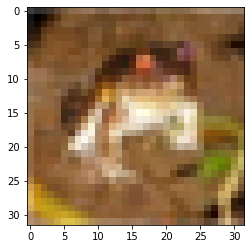

In [24]:
plt.imshow(X_train[0])

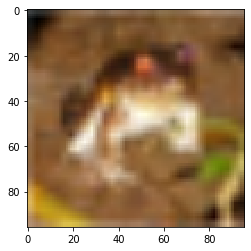

In [25]:
plt.imshow(tf.image.resize(X_train[0],(96,96)).numpy())

In [26]:
X_train_resized = tf.image.resize(X_train,(96,96)).numpy()

In [27]:
X_train_resized.shape

(50000, 96, 96, 3)

In [28]:
base_model.trainable = False

In [29]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [30]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dense(10, activation= 'softmax'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 2,588,490
Trainable params: 330,506
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
model.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

In [34]:
model.fit(X_train_resized,
          y_train_encoded,
          epochs = 300,
          batch_size = 128,
          validation_split = 0.1,
          callbacks= [early])

Epoch 1/300
352/352 [==============================] - 258s 734ms/step - loss: 0.7415 - accuracy: 0.7458 - val_loss: 0.5887 - val_accuracy: 0.7926
Epoch 2/300
352/352 [==============================] - 237s 674ms/step - loss: 0.5372 - accuracy: 0.8116 - val_loss: 0.5327 - val_accuracy: 0.8164
Epoch 3/300
352/352 [==============================] - 236s 672ms/step - loss: 0.4727 - accuracy: 0.8323 - val_loss: 0.5430 - val_accuracy: 0.8126
Epoch 4/300
352/352 [==============================] - 245s 697ms/step - loss: 0.4188 - accuracy: 0.8524 - val_loss: 0.5469 - val_accuracy: 0.8052


In [35]:
model_history = pd.DataFrame(model.history.history)

In [36]:
baseline.evaluate(X_test,y_test_encoded)

313/313 [==============================] - 3s 8ms/step - loss: 0.9493 - accuracy: 0.6626


[0.949306845664978, 0.6625999808311462]

In [39]:
baseline_predictions = baseline.predict_classes(X_test)

In [41]:
print(classification_report(y_test, baseline_predictions))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      1000
           1       0.91      0.59      0.72      1000
           2       0.70      0.47      0.56      1000
           3       0.44      0.58      0.50      1000
           4       0.68      0.64      0.66      1000
           5       0.58      0.58      0.58      1000
           6       0.85      0.68      0.75      1000
           7       0.77      0.69      0.73      1000
           8       0.65      0.89      0.75      1000
           9       0.57      0.91      0.70      1000

    accuracy                           0.66     10000
   macro avg       0.69      0.66      0.66     10000
weighted avg       0.69      0.66      0.66     10000



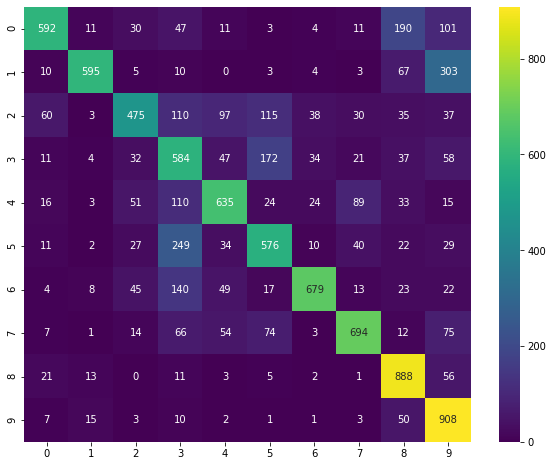

In [53]:
plt.figure(figsize= (10,8))
sns.heatmap(confusion_matrix(y_test, baseline_predictions), annot=True, cmap = 'viridis', fmt='d');

In [43]:
X_test_resized = tf.image.resize(X_test,(96,96)).numpy()

In [44]:
model.evaluate(X_test_resized,y_test_encoded)

313/313 [==============================] - 56s 180ms/step - loss: 0.5615 - accuracy: 0.8128


[0.5614538788795471, 0.8127999901771545]

In [45]:
model_predictions = model.predict_classes(X_test_resized)

In [46]:
print(classification_report(y_test, model_predictions))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1000
           1       0.91      0.90      0.90      1000
           2       0.87      0.68      0.76      1000
           3       0.75      0.59      0.66      1000
           4       0.69      0.86      0.76      1000
           5       0.70      0.78      0.74      1000
           6       0.84      0.86      0.85      1000
           7       0.88      0.80      0.84      1000
           8       0.89      0.88      0.88      1000
           9       0.91      0.89      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



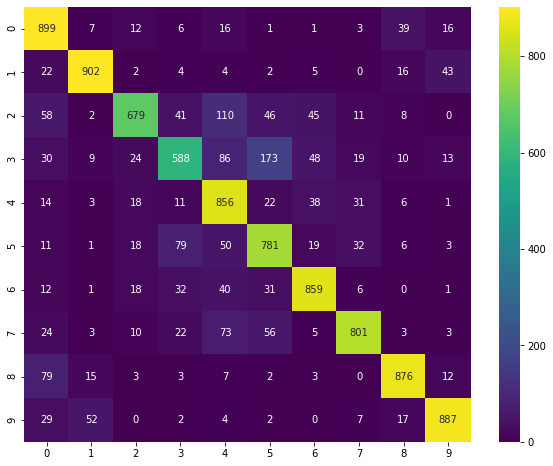

In [55]:
plt.figure(figsize= (10,8))
sns.heatmap(confusion_matrix(y_test, model_predictions), annot=True, cmap = 'viridis', fmt='d');